<a href="https://www.kaggle.com/code/clemwo/competition-nlp-with-disaster-tweets?scriptVersionId=197663783" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
%pip install langdetect
%pip install seaborn --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 11.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993227 sha256=0d0548ddf6e3dcd49dc9671e5700b8346c195fe0b5e6d7b4725920fc3c0cdbfd
  Stored in directory: /root/.cache/pip/wheels/95/03/7d/59ea870c70ce4e5a370638b5462a7711ab78fba2f655d05106
Successfully built langdetect
Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 4.6 MB/s eta 0:00:00
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.12.2
    Uninstalling seaborn-0.12.2:
      Successfully uninstalled seaborn-0.12.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydata-profiling 4.9.0 requires scipy<1.14,>=1.4.1, but you have scipy 1.14.0 which is incompatible

In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('white')
sns.set_context('notebook', font_scale=1.2)

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


<h1 style="font-family: 'Palatino Linotype', 'Book Antiqua', Palatino, serif; font-size: 46px; color: #2C3E50; font-weight: bold; text-align: left; margin-top: 20px; background-color: rgba(0, 138, 216, 0.6); padding: 25px; border-radius: 10px;">
    🔥Competition 🏆 NLP with Disaster Tweets🦜
</h1>

> This notebooks builds models for [Kaggles Desaster Tweets 🦜 competition](https://www.kaggle.com/competitions/nlp-getting-started). The objective is to develop a model to predict which Tweets are about real disasters and which ones are not. The submission evaluation metric is the [F1-Score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html) between the predicted and expected answers. The format of the submission file submission.csv should be as follows:
```
    id,target
    0,0
    2,0
    3,1
    9,0
    11,0
```
> where `1` stands for a tweet describing a real disaster, and `0` otherwise.

In [3]:
tweets = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
print(f"Rows: {tweets.shape[0]:,}")
print(f"Cols: {tweets.shape[1]:,}")
tweets.head(5)

Rows: 7,613
Cols: 5


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


Seems that `text` is the most useful column to use to predict the `target`. However, the columns are described as follows: 

| Column | Description |
|:-------|:------------|
| `keyword` | A keyword from that tweet (this may be blank). | 
| `location` | The location the tweet was sent from (this may be blank). | 
| `text` | The text of the tweet. | 
| `target` | $1$ if the tweet is about a real desaster, $0$ otherwise. |

In [4]:
TWITTER_BLUE = '#008AD8'

<h1 style="font-family: 'Palatino Linotype', 'Book Antiqua', Palatino, serif; font-size: 36px; color: #2C3E50; font-weight: bold; text-align: left; margin-top: 20px; background-color: rgba(0, 138, 216, 0.3); padding: 20px; border-radius: 10px;">
    Overview of the Data
</h1>

In [5]:
stats = pd.DataFrame({
    'Variable Name': tweets.columns,
    'Missing Count': tweets.isnull().sum().values,
    'Missing Rate (%)': 100*tweets.isnull().mean().values,
    'Unique Count': tweets.nunique().values,
    'Unique Rate (%)': 100*tweets.nunique().values / len(tweets)
}).sort_values(['Missing Rate (%)'], ascending=False)
stats

,Variable Name,Missing Count,Missing Rate (%),Unique Count,Unique Rate (%)
2,location,2533,33.272035,3341,43.885459
1,keyword,61,0.801261,221,2.902929
0,id,0,0.000000,7613,100.000000
3,text,0,0.000000,7503,98.555103
4,target,0,0.000000,2,0.026271


- 33% of all the tweets don't have information about their location.
- Only 0.8% of all the tweest don't have information about a keyword from that tweet.
- there are only 221 (2.9%) unique keywords in all the training set.
- There are no empy tweets 😄 Meaning, every tweet has some text.

Frist, we want to visualize the distribution of the target variable in terms of disaster tweets (`1`) and non-disaster tweets (`0`) to check for class imbalance.

/tmp/ipykernel_17/477137470.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='target', data=tweets,
/tmp/ipykernel_17/477137470.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['No Disaster', 'Disaster'])


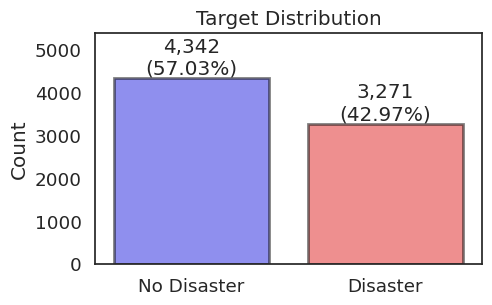

In [6]:
plt.figure(figsize=(5, 3))

ax = sns.countplot(x='target', data=tweets, 
                   linewidth=2.0, edgecolor='black', 
                   palette=['blue', 'red'], alpha=0.5)
ax.set_xticklabels(['No Disaster', 'Disaster'])
ax.set_xlabel('')
ax.set_ylabel('Count')
ax.set_ylim((0, 5_400))
plt.title('Target Distribution')

total = len(tweets)
for p in ax.patches:
    count = p.get_height()
    percentage = f'{100 * count / total:.2f}%'
    ax.text(p.get_x() + p.get_width() / 2, count + 0.5, f'{count:,.0f}\n({percentage})', ha='center', va='bottom')

plt.show()

Let's try to understand the variation of lengths of the tweets in the dataset. 

In [7]:
tweets['text_length'] = tweets['text'].apply(len)
tweets['word_count'] = tweets['text'].apply(lambda x: len(x.split(' ')))

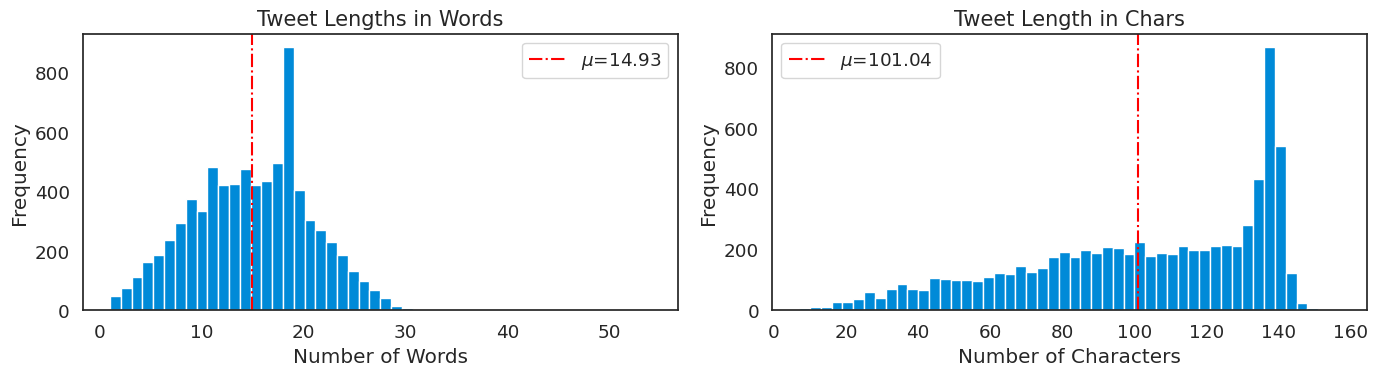

In [8]:
avg_length_words = np.mean(tweets['word_count'])
avg_length_chars = np.mean(tweets['text_length'])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

# --- Length of tweets in words ---
ax1.hist(tweets['word_count'], bins=50, color=TWITTER_BLUE, edgecolor='white')
ax1.axvline(avg_length_words, color='red', linestyle='-.', label=f'$\mu$={avg_length_words:.2f}')
ax1.set_xlabel('Number of Words')
ax1.set_ylabel('Frequency')
ax1.legend()
ax1.set_title('Tweet Lengths in Words', fontsize=15)

# --- Length of tweets in characters ---
ax2.hist(tweets['text_length'], bins=50, color=TWITTER_BLUE, edgecolor='white')
ax2.axvline(avg_length_chars, color='red', linestyle='-.', label=f'$\mu$={avg_length_chars:.2f}')
ax2.set_xlabel('Number of Characters')
ax2.set_ylabel('Frequency')
ax2.legend()
ax2.set_title('Tweet Length in Chars', fontsize=15)

plt.tight_layout()
plt.show()

Now we compare text lengths between disaster and non-disaster tweets.

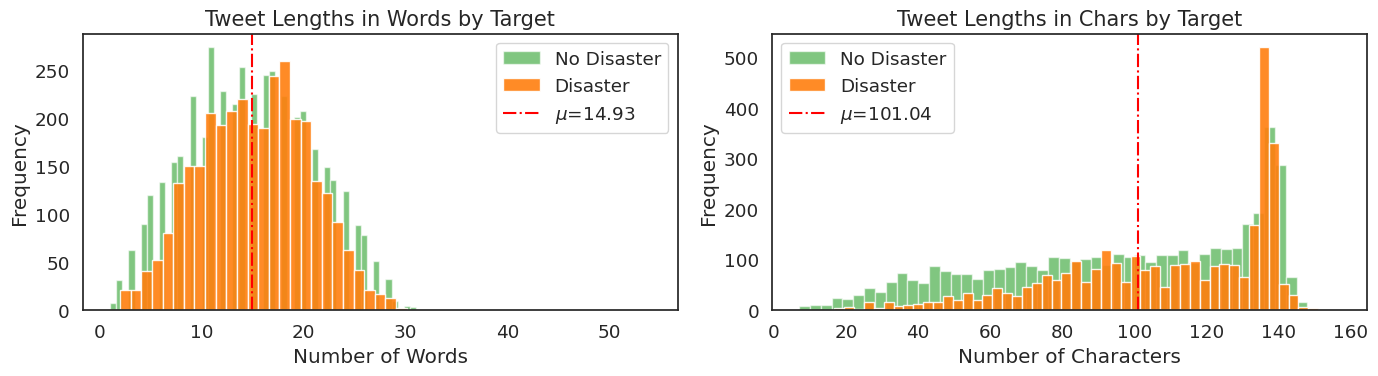

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

# --- Length of tweets in words split by target ---
ax1.hist(tweets[tweets['target'] == 0]['word_count'], bins=50, color='C2', edgecolor='white', alpha=0.6, label='No Disaster')
ax1.hist(tweets[tweets['target'] == 1]['word_count'], bins=50, color='C1', edgecolor='white', alpha=0.9, label='Disaster')
ax1.axvline(avg_length_words, color='red', linestyle='-.', label=f'$\mu$={avg_length_words:.2f}')
ax1.set_xlabel('Number of Words')
ax1.set_ylabel('Frequency')
ax1.legend()
ax1.set_title('Tweet Lengths in Words by Target', fontsize=15)

# --- Length of tweets in characters split by target ---
ax2.hist(tweets[tweets['target'] == 0]['text_length'], bins=50, color='C2', edgecolor='white', alpha=0.6, label='No Disaster')
ax2.hist(tweets[tweets['target'] == 1]['text_length'], bins=50, color='C1', edgecolor='white', alpha=0.9, label='Disaster')
ax2.axvline(avg_length_chars, color='red', linestyle='-.', label=f'$\mu$={avg_length_chars:.2f}')
ax2.set_xlabel('Number of Characters')
ax2.set_ylabel('Frequency')
ax2.legend()
ax2.set_title('Tweet Lengths in Chars by Target', fontsize=15)

plt.tight_layout()
plt.show()

Let's also take a look at the same visualization but using a boxplot instead. 

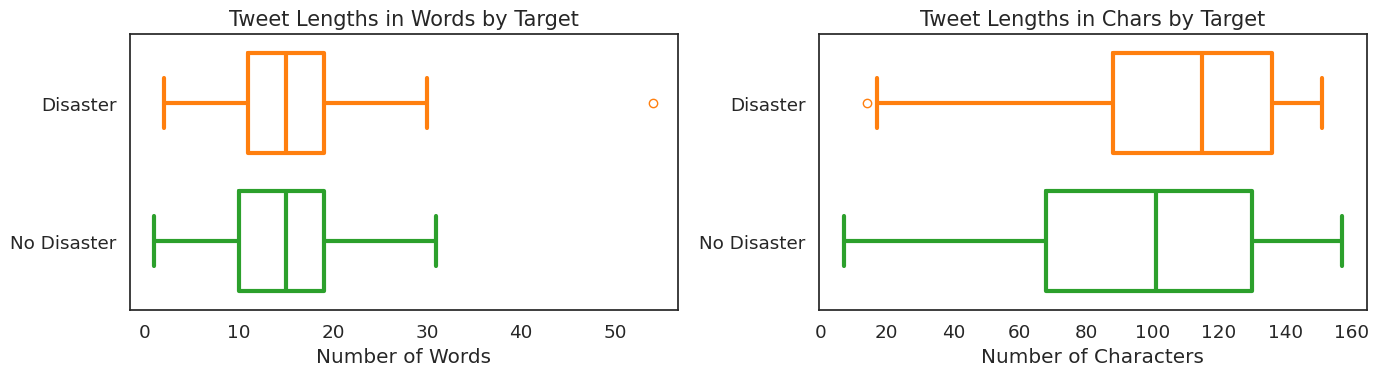

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

# --- Length of tweets in words ---
sns.boxplot(data=tweets, x='word_count', hue='target', orient='h', fill=False,
            y=['No Disaster' if t == 0 else 'Disaster' for t in tweets['target']], 
            linewidth=3.0, legend=False, ax=ax1, gap=0.1, palette=['C2', 'C1'])
ax1.set_xlabel('Number of Words')
ax1.set_title('Tweet Lengths in Words by Target', fontsize=15)

# --- Length of tweets in characters ---
sns.boxplot(data=tweets, x='text_length', hue='target', orient='h', fill=False,
            y=['No Disaster' if t == 0 else 'Disaster' for t in tweets['target']], 
            linewidth=3.0, legend=False, ax=ax2, gap=0.1, palette=['C2', 'C1'])
ax2.set_xlabel('Number of Characters')
ax2.set_title('Tweet Lengths in Chars by Target', fontsize=15)

plt.tight_layout()
plt.show()

Now, we will check the correlation between the `word_count` and the `text_length`.

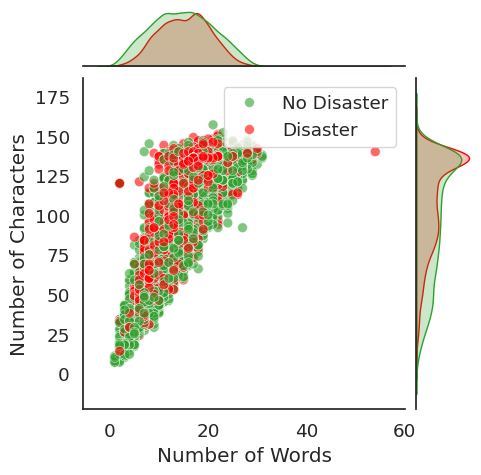

In [11]:
palette = {0: 'C2', 1: 'red'}

g = sns.jointplot(
    data=tweets, 
    x="word_count", 
    y="text_length", 
    hue="target", 
    height=5, 
    palette=palette, 
    joint_kws={'s': 50, 'alpha': 0.6}
)
plt.xlabel('Number of Words')
plt.ylabel('Number of Characters')

handles, labels = g.ax_joint.get_legend_handles_labels()
g.ax_joint.legend(handles, ['No Disaster', 'Disaster'], loc='upper right')

plt.show()

<h1 style="font-family: 'Palatino Linotype', 'Book Antiqua', Palatino, serif; font-size: 36px; color: #2C3E50; font-weight: bold; text-align: left; margin-top: 20px; background-color: rgba(0, 138, 216, 0.3); padding: 20px; border-radius: 10px;">
    Top Words and N-grams
</h1>

In this section we are going to perform Tokenization and Frequency Analysis.
- __Tokenization__: Tokenize the text and remove stopwords.
- __Frequency Analysis__: Identify the most frequent words, bigrams, and trigrams in each class.

In [12]:
from sklearn.feature_extraction.text import CountVectorizer

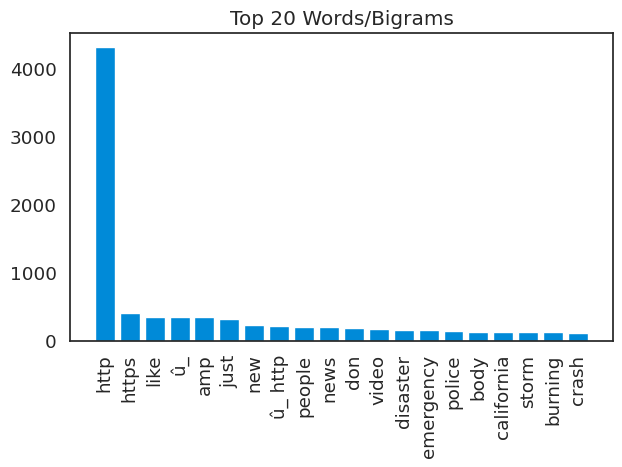

In [13]:
vectorizer = CountVectorizer(stop_words='english', ngram_range=(1,2))
X = vectorizer.fit_transform(tweets['text'])

sum_words = X.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)

top_20 = words_freq[:20]
words, counts = zip(*top_20)

plt.figure(figsize=(7, 4))

plt.bar(words, counts, color=TWITTER_BLUE)
plt.xticks(rotation=90)
plt.title('Top 20 Words/Bigrams')

plt.show()

<h1 style="font-family: 'Palatino Linotype', 'Book Antiqua', Palatino, serif; font-size: 36px; color: #2C3E50; font-weight: bold; text-align: left; margin-top: 20px; background-color: rgba(0, 138, 216, 0.3); padding: 20px; border-radius: 10px;">
    Word Clouds
</h1>

Now we create word clouds for disaster and non-disaster tweets to visualize prominent terms.


In [14]:
from wordcloud import WordCloud

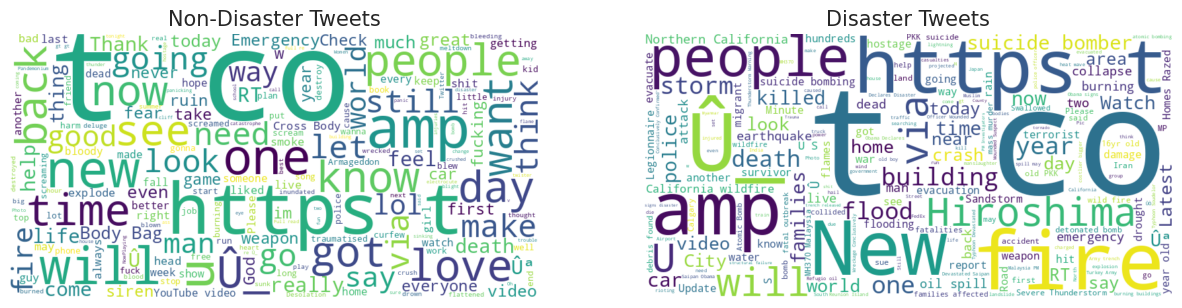

In [15]:
disaster_text = ' '.join(tweets[tweets['target'] == 1]['text'])
non_disaster_text = ' '.join(tweets[tweets['target'] == 0]['text'])

wordcloud_disaster = WordCloud(width=800, height=400, background_color='white').generate(disaster_text)
wordcloud_non_disaster = WordCloud(width=800, height=400, background_color='white').generate(non_disaster_text)

plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
plt.imshow(wordcloud_non_disaster, interpolation='bilinear')
plt.title('Non-Disaster Tweets', fontsize=15)
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(wordcloud_disaster, interpolation='bilinear')
plt.title('Disaster Tweets', fontsize=15)
plt.axis('off')

plt.show()


We clearly see a discrepancy in the words used in disaster tweets compared to words used in non-disaster tweets. For example, `suicide bomber` seems to be a word occuring often in disaster tweets while it's not occuring in non-disaster tweets. However, the most common words are `t` and `co` in both, disaster and non-disaster tweets. 

__Words Highly Occuring Only in Disaster Tweets__ (following shows a subset): 
```
    fire
    suicide bomber
    hiroshima
    building
    storm
    earthquake
    death
```

__Words Highly Occuring Only in Non-Disaster Tweets__ (following shows a subset): 
```
    people
    good
    day
    going 
    love
    help
    new
```

<h1 style="font-family: 'Palatino Linotype', 'Book Antiqua', Palatino, serif; font-size: 36px; color: #2C3E50; font-weight: bold; text-align: left; margin-top: 20px; background-color: rgba(0, 138, 216, 0.3); padding: 20px; border-radius: 10px;">
    Hashtags
</h1>

Here we extract hashtags from the text and analyze their frequency.

In [16]:
import re
from collections import Counter

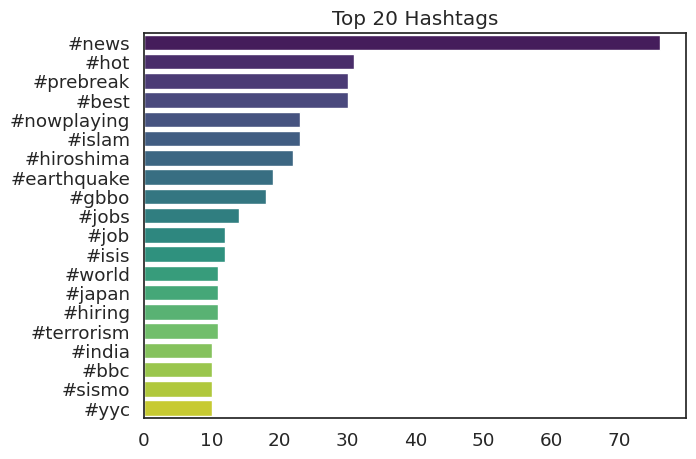

In [17]:
tweets['hashtags'] = tweets['text'].apply(lambda x: re.findall(r'#\w+', x.lower()))
all_hashtags = [hashtag for hashtags in tweets['hashtags'] for hashtag in hashtags]
hashtag_counts = Counter(all_hashtags)

top_hashtags = hashtag_counts.most_common(20)
hashtags, counts = zip(*top_hashtags)

plt.figure(figsize=(7, 5))

sns.barplot(x=list(counts), y=list(hashtags), hue=list(hashtags), 
            palette='viridis', dodge=False, legend=False)
plt.title('Top 20 Hashtags')

plt.show()

<h1 style="font-family: 'Palatino Linotype', 'Book Antiqua', Palatino, serif; font-size: 36px; color: #2C3E50; font-weight: bold; text-align: left; margin-top: 20px; background-color: rgba(0, 138, 216, 0.3); padding: 20px; border-radius: 10px;">
    Named Entity Recognition (NER)
</h1>

In this section we want to identify locations and organizations. We aim to extract entities like locations, organizations, and persons.

In [18]:
import spacy

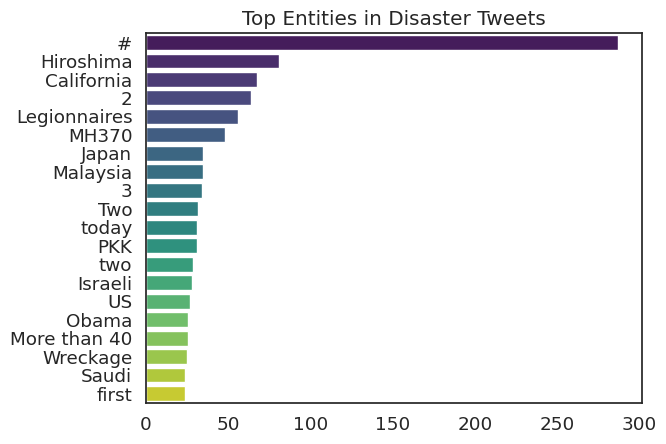

In [19]:
nlp = spacy.load('en_core_web_sm')

def extract_entities(text):
    doc = nlp(text)
    return [ent.text for ent in doc.ents]

tweets['entities'] = tweets['text'].apply(extract_entities)

disaster_entities = [ent for ents in tweets[tweets['target'] == 1]['entities'] for ent in ents]
disaster_entity_counts = Counter(disaster_entities).most_common(20)

entities, counts = zip(*disaster_entity_counts)
sns.barplot(x=list(counts), y=list(entities), hue=list(entities), 
            palette='viridis', dodge=False, legend=False)
plt.title('Top Entities in Disaster Tweets')
plt.show()

<h1 style="font-family: 'Palatino Linotype', 'Book Antiqua', Palatino, serif; font-size: 36px; color: #2C3E50; font-weight: bold; text-align: left; margin-top: 20px; background-color: rgba(0, 138, 216, 0.3); padding: 20px; border-radius: 10px;">
    Sentiment Analysis
</h1>

In [20]:
from textblob import TextBlob

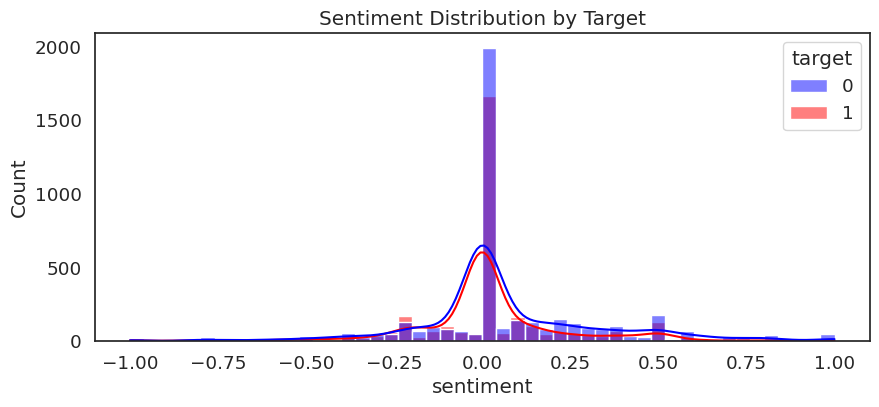

In [21]:
tweets['sentiment'] = tweets['text'].apply(lambda x: TextBlob(x).sentiment.polarity)

plt.figure(figsize=(10, 4))

sns.histplot(data=tweets, x='sentiment', bins=50, kde=True, hue='target', palette=['blue', 'red'])
plt.title('Sentiment Distribution by Target')

plt.show()

<h1 style="font-family: 'Palatino Linotype', 'Book Antiqua', Palatino, serif; font-size: 36px; color: #2C3E50; font-weight: bold; text-align: left; margin-top: 20px; background-color: rgba(0, 138, 216, 0.3); padding: 20px; border-radius: 10px;">
    Language Detection
</h1>

Before we apply further methods, let's detect the language (just for the fun of it).

In [22]:
from langdetect import detect

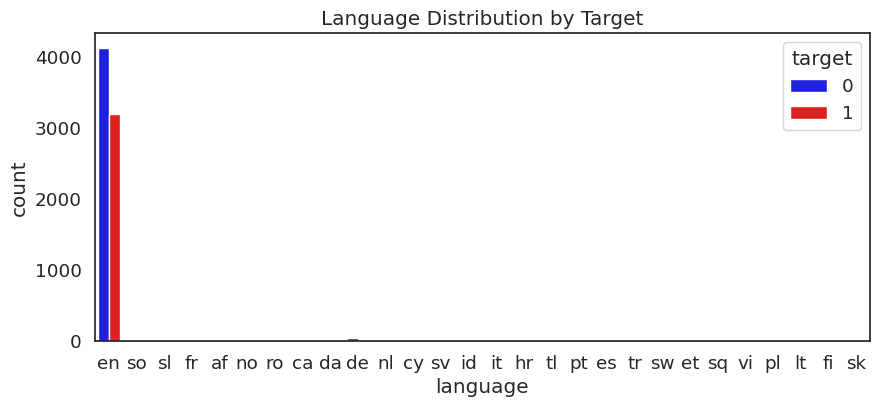

In [23]:
plt.figure(figsize=(10, 4))

tweets['language'] = tweets['text'].apply(lambda x: detect(x) if isinstance(x, str) else 'unknown')
sns.countplot(x='language', hue='target', data=tweets, palette=['blue', 'red'])
plt.title('Language Distribution by Target')

plt.show()

It's english 🇺🇸, who would have thought that 🤭 Jokes aside, actually there are also some other language present. Only in small occurences though.

<h1 style="font-family: 'Palatino Linotype', 'Book Antiqua', Palatino, serif; font-size: 36px; color: #2C3E50; font-weight: bold; text-align: left; margin-top: 20px; background-color: rgba(0, 138, 216, 0.3); padding: 20px; border-radius: 10px;">
    TF-IDF Analysis
</h1>

Now we want to identify important terms using [TF-IDF](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html).

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [25]:
tfidf = TfidfVectorizer(stop_words='english', max_features=20)
tfidf_matrix = tfidf.fit_transform(tweets['text'])

tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out())
tfidf_df.describe()

,amp,body,burning,california,crash,disaster,don,emergency,http,https,just,like,new,news,people,police,storm,suicide,video,û_
count,7613.000000,7613.000000,7613.000000,7613.000000,7613.000000,7613.000000,7613.000000,7613.000000,7613.000000,7613.000000,7613.000000,7613.000000,7613.000000,7613.000000,7613.000000,7613.000000,7613.000000,7613.000000,7613.000000,7613.000000
mean,0.033593,0.014463,0.013310,0.013157,0.012645,0.016188,0.021662,0.017099,0.357003,0.045747,0.035716,0.037536,0.022965,0.019989,0.021835,0.014483,0.013459,0.013113,0.016955,0.034112
std,0.168653,0.111561,0.107924,0.105836,0.105745,0.120753,0.139408,0.120906,0.434663,0.197194,0.175728,0.180029,0.135807,0.127628,0.136828,0.112153,0.108690,0.107581,0.119538,0.160718
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


<h1 style="font-family: 'Palatino Linotype', 'Book Antiqua', Palatino, serif; font-size: 36px; color: #2C3E50; font-weight: bold; text-align: left; margin-top: 20px; background-color: rgba(0, 138, 216, 0.3); padding: 20px; border-radius: 10px;">
    Topic Modeling (LDA)
</h1>

Now let's try to discover unrelated topics in tweets by applying [Latent Dirichlet Allocation](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation) (LDA).

In [26]:
from sklearn.decomposition import LatentDirichletAllocation

In [27]:
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(tfidf_matrix)

for idx, topic in enumerate(lda.components_):
    print(f"Topic {idx}:")
    print([tfidf.get_feature_names_out()[i] for i in topic.argsort()[-10:]])

Topic 0:
['amp', 'video', 'body', 'people', 'û_', 'crash', 'emergency', 'new', 'like', 'http']
Topic 1:
['people', 'don', 'https', 'news', 'emergency', 'new', 'like', 'http', 'amp', 'just']
Topic 2:
['new', 'crash', 'emergency', 'like', 'http', 'burning', 'police', 'disaster', 'video', 'don']
Topic 3:
['û_', 'emergency', 'crash', 'new', 'like', 'http', 'california', 'news', 'people', 'https']
Topic 4:
['https', 'crash', 'like', 'emergency', 'new', 'suicide', 'storm', 'body', 'http', 'û_']


<h1 style="font-family: 'Palatino Linotype', 'Book Antiqua', Palatino, serif; font-size: 36px; color: #2C3E50; font-weight: bold; text-align: left; margin-top: 20px; background-color: rgba(0, 138, 216, 0.3); padding: 20px; border-radius: 10px;">
    Correlations
</h1>

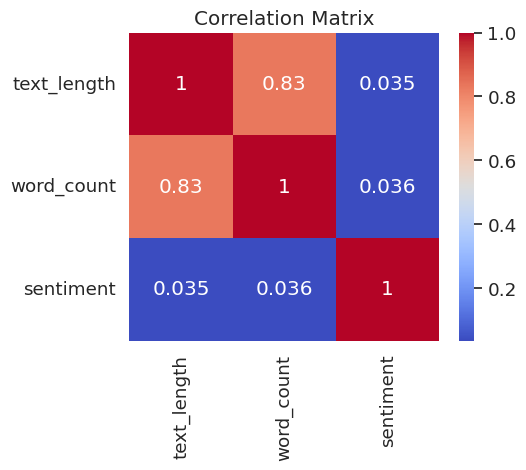

In [28]:
numerical_features = ['text_length', 'word_count', 'sentiment']

plt.figure(figsize=(5, 4))

sns.heatmap(tweets[numerical_features].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')

plt.show()

---

💚 Thank you for reading 💚

If you have any questions or feedback, feel free to leave a comment 🤔

This notebook is __still in progress__.

Please __UPVOTE__ if you enjoyed this notebook 🙏